# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

In [5]:
import numpy as np
import pandas as pd
from PIL import Image
import IPython.display
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import torch
import os

In [3]:
import transformers
print(transformers.__version__)

4.38.1


In [4]:
print(torch.__version__)

2.2.0+cu121


In [5]:
import PIL
print(PIL.__version__)

10.2.0


# Load data

In [6]:
df_caption = pd.read_csv("data/description.csv")
df_caption

,filename,image_name,description
0,page.png,page,a page of text about segmentation
1,chelsea.png,chelsea,a facial photo of a tabby cat
2,astronaut.png,astronaut,a portrait of an astronaut with the American flag
3,rocket.jpg,rocket,a rocket standing on a launchpad
4,motorcycle_right.png,motorcycle_right,a red motorcycle standing in a garage
5,camera.png,camera,a person looking at a camera on a tripod
6,salmon.png,salmon,a cat standing at the window
7,coffee.png,coffee,a cup of coffee on a saucer
8,dog.png,dog,a white tidy dog coming to you


In [8]:
df_caption[df_caption["image_name"]=="chelsea"].reset_index()["description"][0]

'a facial photo of a tabby cat'

In [7]:
file_list = df_caption["filename"].to_list()
file_list

['page.png',
 'chelsea.png',
 'astronaut.png',
 'rocket.jpg',
 'motorcycle_right.png',
 'camera.png',
 'salmon.png',
 'coffee.png',
 'dog.png']

In [7]:
os.path.splitext("page.png")[0]

'page'

# Load the pretrained CLIP model

In [8]:
# Set the device
device = "cpu"
# Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Save the model to device
model = CLIPModel.from_pretrained(model_ID).to(device)
# Get the processor
processor = CLIPProcessor.from_pretrained(model_ID)
# Get the tokenizer
tokenizer = CLIPTokenizer.from_pretrained(model_ID)

# Create function to generate text and image embeddings

In [9]:
def single_text_embedding(text):
  inputs = tokenizer(text, return_tensors = "pt")
  text_embedding = model.get_text_features(**inputs)
  # convert the embeddings to numpy array
  embedding_as_np = text_embedding.cpu().detach().numpy()
  return embedding_as_np

def single_image_embedding(my_image):
  image = processor(
		text = None,
		images = my_image,
		return_tensors="pt"
		)["pixel_values"].to(device)
  image_embedding = model.get_image_features(image)
  # convert the embeddings to numpy array
  embedding_as_np = image_embedding.cpu().detach().numpy()
  return embedding_as_np

# Apply the functions to images and their descriptions

In [10]:
dir_path = "data/image/"

text_embs = []
img_embs = []
texts = []
original_images = []
for filename in file_list:
    name = os.path.splitext(filename)[0]
    description = df_caption[df_caption["image_name"]==name].reset_index()["description"][0]
    text_embs.append(single_text_embedding(description))
    image = Image.open(os.path.join(dir_path, filename)).convert("RGB")
    img_embs.append(single_image_embedding(image))
    texts.append(description)
    original_images.append(image)

text_embs_np = np.vstack(text_embs)
img_embs_np = np.vstack(img_embs)

# Compare cosine similarity between text features and image features

In [11]:
img_embs = torch.from_numpy(img_embs_np)
text_embs = torch.from_numpy(text_embs_np)

img_embs /= img_embs.norm(dim=-1, keepdim=True)
text_embs /= text_embs.norm(dim=-1, keepdim=True)
similarity = text_embs.cpu().numpy() @ img_embs.cpu().numpy().T

In [12]:
similarity

array([[0.35866567, 0.22134374, 0.17072266, 0.1812528 , 0.18276983,
        0.2255907 , 0.18975472, 0.22676612, 0.20572275],
       [0.10226346, 0.31246883, 0.1281625 , 0.12455073, 0.1253066 ,
        0.16481064, 0.2501477 , 0.1642366 , 0.1570575 ],
       [0.10536596, 0.16986665, 0.28642964, 0.21966493, 0.1529135 ,
        0.17051601, 0.17123339, 0.13632432, 0.16876009],
       [0.15561022, 0.1724073 , 0.19041   , 0.302855  , 0.14778094,
        0.20366764, 0.19243535, 0.12739204, 0.15358095],
       [0.10539818, 0.15949672, 0.16822016, 0.15346083, 0.34004828,
        0.11860573, 0.16559541, 0.12209146, 0.11915663],
       [0.17048922, 0.2230405 , 0.19209638, 0.20324133, 0.16374263,
        0.3247835 , 0.17879148, 0.14612839, 0.17648558],
       [0.10025349, 0.24311891, 0.12376247, 0.13504805, 0.1425119 ,
        0.16603753, 0.2981164 , 0.15660788, 0.15358225],
       [0.15014924, 0.1946552 , 0.16691422, 0.13780385, 0.13398114,
        0.1865728 , 0.21315992, 0.2941222 , 0.1862302 ],


Text(0.5, 1.0, 'Cosine similarity between text and image features')

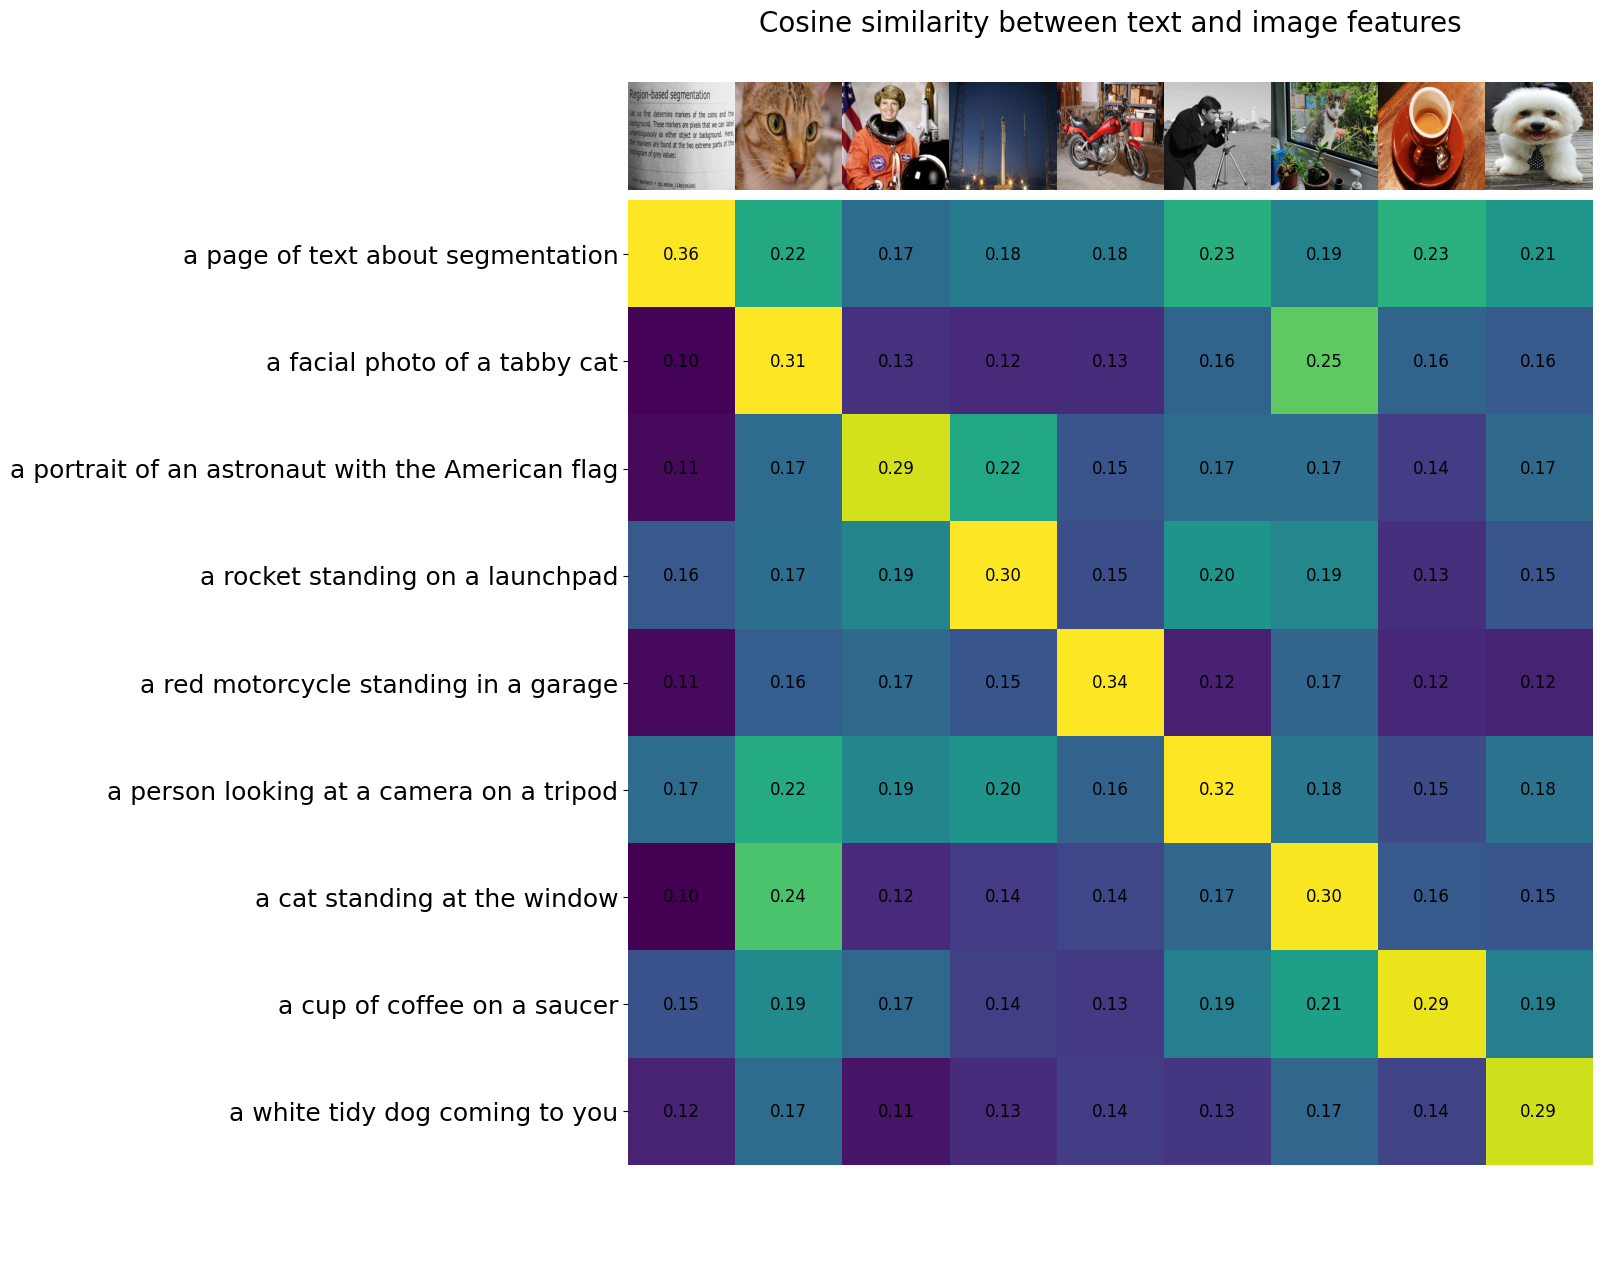

In [13]:
count = df_caption.shape[0]

plt.figure(figsize=(20, 16))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Do text-image search using FAISS

In [15]:
import faiss

In [16]:
def find_image(qr_sentence, img_embs_np):
    # generate vector for query sentence
    qr_sent_vec = single_text_embedding(qr_sentence)

    # perform vector search through similarity comparison
    n_dim = img_embs_np.shape[1]
    x = np.vstack(img_embs_np).astype(np.float32)
    q = qr_sent_vec.reshape(1, -1)
    index = faiss.index_factory(n_dim, "Flat", faiss.METRIC_INNER_PRODUCT)
    # add all questions
    faiss.normalize_L2(x)
    index.add(x)
    # do vector search for the query sentence
    faiss.normalize_L2(q)
    similarity, idx = index.search(q, k=index.ntotal)
    img_idx = idx[0][0]
    image = Image.open(os.path.join(dir_path, file_list[img_idx])).convert("RGB")
    return image

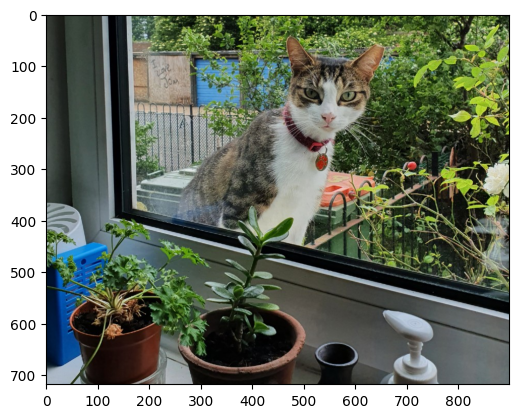

In [17]:
qr_sentence = "there is a cat outside window"
response_img = find_image(qr_sentence, img_embs_np)
plt.imshow(response_img)

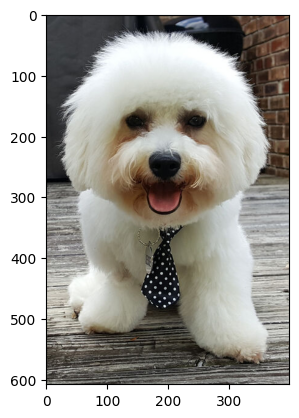

In [18]:
qr_sentence = "there is a dog watching you"
response_img = find_image(qr_sentence, img_embs_np)
plt.imshow(response_img)